<a href="https://colab.research.google.com/github/tanvipathak/Machine-Learning-from-scratch/blob/master/main_artist_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Artist Recommender using KNeighbors Algorithm on Spotify Data:
### By: Tanvi Pathak (18070124072) Hridyesh Bisht(18070124030) and Sejal Shrestha (18070124064) 

# Introduction

This is a notebook trying to find you the best alternatives to your favorite musician. The input data is a list of about 30,000 artists from all over the world defined by their most common style features. This recommender returns the most similar artists for a queried musician.

We have used a simple KNeighborsRegressor model from Scikit Learn to define the nearest neighbors of the given artists in the data set. 


## Mounting data set into google drive 


In [ ]:
from google.colab import drive
drive.flush_and_unmount()

Drive not mounted, so nothing to flush and unmount.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

In [ ]:
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [ ]:
!kaggle datasets download -d yamaerenay/spotify-dataset-19212020-160k-tracks

4/1AY0e-g7UOnv9QKTOCnjI7MR4CIsVz4_CBmTUeqx0maxyR_bsYdfp3ODq-IUDownloading spotify-dataset-19212020-160k-tracks.zip to /content/gdrive/My Drive/Kaggle
 97% 190M/195M [00:03<00:00, 92.6MB/s]
100% 195M/195M [00:03<00:00, 57.2MB/s]


In [ ]:
!unzip \*.zip  && rm *.zip

## Importing libraries

In [ ]:
# TABLES & VIS
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ast import literal_eval 
import numpy as np

# NLTK
import regex as re
import unicodedata

#Sklearn
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import classification_report,accuracy_score,precision_score,recall_score,f1_score

# The Dataset 

The data set provided on [Kaggle](https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks?select=data_by_artist_o.csv).
1. It has a total of 29,000 artists and their audio features.
2. The features are aggregated by mean (for numerical) and mode (for categorical values). 

In [ ]:
df = pd.read_csv('/content/gdrive/My Drive/Kaggle/data_by_artist_o.csv')
df.shape

(28680, 16)

In [ ]:
df.sample(10)

,genres,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count
14581,"['chicago drill', 'chicago rap', 'drill', 'hip...",Lil Durk,0.183778,0.749120,188932.840000,0.572820,0.000002,0.139886,-7.222940,0.306650,132.989740,0.421734,66.800000,1,0,50
9905,[],Hal Hopper,0.820000,0.680000,207467.000000,0.378000,0.000056,0.191000,-14.928000,0.284000,104.120000,0.624000,12.000000,6,1,1
12402,[],Johnny Jenkins,0.361400,0.647800,258993.200000,0.684000,0.130780,0.184460,-9.825600,0.030860,93.665000,0.924800,34.200000,0,1,5
23063,"['chicano rap', 'g funk', 'gangster rap', 'wes...",South Central Cartel,0.258000,0.916000,326533.000000,0.794000,0.000000,0.090900,-6.897000,0.259000,111.672000,0.712000,35.000000,7,1,2
9388,"['emo rap', 'melodic rap', 'sad rap', 'undergr...",Global Dan,0.046100,0.552000,180080.000000,0.733000,0.000000,0.070300,-6.626000,0.202000,159.818000,0.333000,61.000000,6,1,1
8691,"['gangster rap', 'hardcore hip hop', 'hip hop'...",G-Unit,0.085939,0.698769,221378.500000,0.764385,0.000000,0.125312,-3.396731,0.286862,97.181346,0.693346,52.961538,11,0,26
24536,"['adult standards', 'brill building pop', 'cla...",The Chordettes,0.938258,0.436152,140244.893939,0.114586,0.000333,0.207173,-15.628712,0.049330,105.777939,0.204612,11.515152,5,1,132
27984,"['contemporary country', 'country', 'country r...",Zac Brown Band,0.256453,0.608922,230299.987013,0.665636,0.000306,0.157164,-6.066182,0.039584,125.412935,0.554403,53.857143,6,1,77
25305,"['ambient', 'ambient house', 'electronica', 'i...",The Orb,0.015900,0.666000,259267.000000,0.669500,0.274500,0.430000,-14.510500,0.045250,105.003000,0.582000,36.000000,6,0,4
23464,['southern rock'],Still Water,0.000116,0.577000,189093.000000,0.812000,0.000255,0.065000,-6.075000,0.053600,128.810000,0.735000,40.000000,9,1,2


In [ ]:
df.dtypes

genres               object
artists              object
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
liveness            float64
loudness            float64
speechiness         float64
tempo               float64
valence             float64
popularity          float64
key                   int64
mode                  int64
count                 int64
dtype: object

# Features 

## Overview

In [ ]:
print(f'It contains the following features \n{list(df.columns)}')

It contains the following features 
['genres', 'artists', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'popularity', 'key', 'mode', 'count']


In [ ]:
print(f'The data set has {(df.dtypes != "object").sum()} numerical features')

The data set has 14 numerical features


In [ ]:
df.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count
count,28680.000000,28680.000000,2.868000e+04,28680.000000,28680.000000,28680.000000,28680.000000,28680.000000,28680.000000,28680.000000,28680.000000,28680.000000,28680.000000,28680.000000
mean,0.498373,0.546490,2.388780e+05,0.497488,0.174756,0.202441,-11.140498,0.094014,115.844830,0.512723,34.060945,5.412901,0.759170,13.847211
std,0.370614,0.176474,1.211318e+05,0.254885,0.298406,0.140884,5.771749,0.111986,25.003834,0.244421,22.376438,3.480552,0.427595,53.372544
min,0.000000,0.000000,1.879550e+04,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.122296,0.431000,1.823304e+05,0.283568,0.000004,0.110363,-13.972292,0.039200,99.366500,0.329000,12.000000,2.000000,1.000000,2.000000
50%,0.478458,0.557000,2.186400e+05,0.504000,0.001880,0.161000,-10.088938,0.052200,115.357400,0.523243,39.000000,6.000000,1.000000,3.000000
75%,0.896000,0.675000,2.684670e+05,0.702783,0.215291,0.247000,-6.889000,0.095300,129.848750,0.703000,51.000000,8.000000,1.000000,8.000000
max,0.996000,0.986000,5.403500e+06,1.000000,1.000000,0.991000,1.342000,0.964000,217.743000,0.991000,93.000000,11.000000,1.000000,3169.000000


## Feature relation

In [ ]:
# Pairplot to inspect the correlations between the features, by removing features which don't seem to have any descriptive correlation. 
## Such as acousticness<>speachiness
pair = sns.pairplot(df.drop(columns=['genres', 
                                     'artists', 
                                     'count', 
                                     'mode', 
                                     'key', 
                                     'duration_ms', 
                                     'instrumentalness',
                                     'acousticness']))
pair

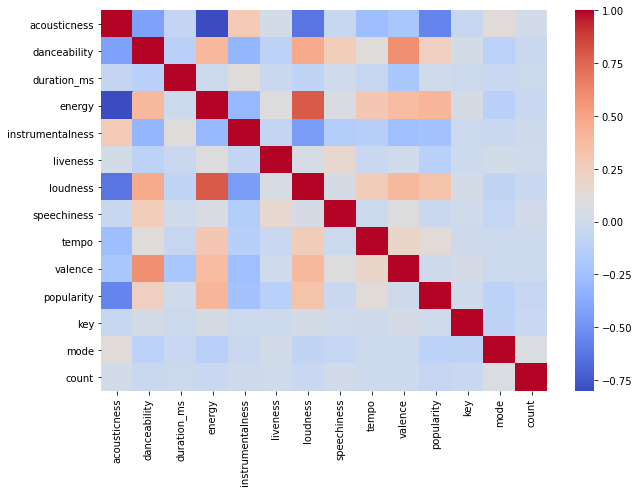

In [ ]:
# Another way of analysing correlations - The Heatmap 
corr = df.corr()
plt.figure(figsize=(10,7))
heatmap = sns.heatmap(corr, cmap='coolwarm')

## Missing Values

In [ ]:
# checking for NaNs
print(f'There are {sum(df.isnull().sum())} NaN values in the data set')

There are 0 NaN values in the data set


In [ ]:
# Inspecting genres
print(f'empty genre lists: {sum([len(list(x)) == 0 for x in df["genres"]])} in the rows')

empty genre lists: 0 in the rows


In [ ]:
print(f'A total of {df[df["genres"]==0].shape[0]} entries have 0 genres')

A total of 0 entries have 0 genres


In [ ]:
# inspecting popularity
print(f'A total of {df[df["popularity"]==0].shape[0]} entries have 0 popularity')

A total of 4368 entries have 0 popularity


Missing values at features ```genres```, ```instrumentalness```, ```popularity``` should be dropped from the data set in order not to have an unbalanced and biased model.

# Preprocessing

## Genres

Converting Genres into categorical data

In [ ]:
# Normalizing the genres column
genres = pd.DataFrame()
genres['genres'] = df.genres.apply(lambda x: literal_eval(x)) 
avail_genres = []
for lst in genres.genres:
    lst = [x.replace(' ', '_') for x in lst]
    _ = [avail_genres.append(x) for x in lst if len(lst) > 0]
counts = {i:avail_genres.count(i) for i in avail_genres}
#converting your apparent standard (comma-separated string) into a Python sequence
genres_ = pd.DataFrame.from_dict(counts, 
                                 orient='index', 
                                 columns=['count']).sort_values(by='count', 
                                                                ascending=False)

In [ ]:
# Copying to have easy access to original values
df_enc = df.copy()

In [ ]:
# populating the top 50 genres as OHE in df_enc and nan values to be filled with 'rock'
top_50 = genres_.head(50).index
def OHE_genres(df=df_enc, top_50=top_50, fillna='rock'):
    df_cop = df.copy()
    df_cop[top_50] = 0
    for c, row in df_cop.iterrows():
        for i in top_50:
            if i in row['genres']:
                df_cop.loc[c, i] = 1
        if all(row[top_50] == 0):
            df_cop.loc[c, fillna] = 1
            
    return df_cop 
  
  #takes only index labels and returns row or dataframe if the index label exists in the caller data frame.

In [ ]:
df_enc = OHE_genres()

In [ ]:
pd.set_option('display.max_columns', None)
df_enc.head(5)

,genres,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count,rock,pop,dance_pop,rap,hip_hop,pop_rap,pop_rock,modern_rock,country_rock,urban_contemporary,folk_rock,latin,soft_rock,trap,mellow_gold,funk,classic_rock,adult_standards,pop_dance,indie_pop,alternative_rock,southern_hip_hop,album_rock,indie_rock,gangster_rap,alternative_metal,country,regional_mexican,new_wave_pop,soul,r&b,post-teen_pop,tropical,quiet_storm,folk,hard_rock,art_rock,dance_rock,classical_performance,roots_rock,edm,brill_building_pop,indie_folk,electropop,contemporary_country,hip_pop,blues_rock,underground_hip_hop,corrido,stomp_and_holler
0,['show tunes'],"""Cats"" 1981 Original London Cast",0.590111,0.467222,250318.555556,0.394003,0.011400,0.290833,-14.448000,0.210389,117.518111,0.389500,38.333333,5,1,9,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,[],"""Cats"" 1983 Broadway Cast",0.862538,0.441731,287280.000000,0.406808,0.081158,0.315215,-10.690000,0.176212,103.044154,0.268865,30.576923,5,1,26,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,[],"""Fiddler On The Roof” Motion Picture Chorus",0.856571,0.348286,328920.000000,0.286571,0.024593,0.325786,-15.230714,0.118514,77.375857,0.354857,34.857143,0,1,7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,[],"""Fiddler On The Roof” Motion Picture Orchestra",0.884926,0.425074,262890.962963,0.245770,0.073587,0.275481,-15.639370,0.123200,88.667630,0.372030,34.851852,0,1,27,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,[],"""Joseph And The Amazing Technicolor Dreamcoat""...",0.510714,0.467143,270436.142857,0.488286,0.009400,0.195000,-10.236714,0.098543,122.835857,0.482286,43.000000,5,1,7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Popularity

Replacing nan with Median

In [ ]:
# replacing with the median (distribution is quite normal)
median_pop = df_enc[df_enc['popularity'] > 0].popularity.median()
df_enc['popularity'] = df_enc.popularity.replace(0.0, median_pop)

In [ ]:
df_enc.popularity.min()

0.009708737864077669

## Instrumentalness

The feature will be dropped as about 65% of the feature are close to 0

In [ ]:
df_enc = df_enc.drop(columns='instrumentalness')

In [ ]:
df_enc.head(3)

,genres,artists,acousticness,danceability,duration_ms,energy,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count,rock,pop,dance_pop,rap,hip_hop,pop_rap,pop_rock,modern_rock,country_rock,urban_contemporary,folk_rock,latin,soft_rock,trap,mellow_gold,funk,classic_rock,adult_standards,pop_dance,indie_pop,alternative_rock,southern_hip_hop,album_rock,indie_rock,gangster_rap,alternative_metal,country,regional_mexican,new_wave_pop,soul,r&b,post-teen_pop,tropical,quiet_storm,folk,hard_rock,art_rock,dance_rock,classical_performance,roots_rock,edm,brill_building_pop,indie_folk,electropop,contemporary_country,hip_pop,blues_rock,underground_hip_hop,corrido,stomp_and_holler
0,['show tunes'],"""Cats"" 1981 Original London Cast",0.590111,0.467222,250318.555556,0.394003,0.290833,-14.448000,0.210389,117.518111,0.389500,38.333333,5,1,9,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,[],"""Cats"" 1983 Broadway Cast",0.862538,0.441731,287280.000000,0.406808,0.315215,-10.690000,0.176212,103.044154,0.268865,30.576923,5,1,26,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,[],"""Fiddler On The Roof” Motion Picture Chorus",0.856571,0.348286,328920.000000,0.286571,0.325786,-15.230714,0.118514,77.375857,0.354857,34.857143,0,1,7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Target

For the artist recommender we only want to find out the vicinity of artists to each other. Therefore we won't need a ```target```.

In [ ]:
df_enc['target'] = 0

In [ ]:
df_enc.drop(columns=['artists', 'genres', 'target']).shape

(28680, 63)

# Model

We have a very simple KNeighbors model to define the artists which are lying close to each other measured by the given input features. 

In [ ]:
# Define X and y
X = df_enc.drop(columns=['artists', 'genres', 'target']) # Remove non numerical features
y = df_enc['target']

knn_model = KNeighborsRegressor().fit(X, y) # Instanciate and train model

pred = knn_model.predict(X)
print(classification_report(y,pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28680

    accuracy                           1.00     28680
   macro avg       1.00      1.00      1.00     28680
weighted avg       1.00      1.00      1.00     28680



# Recommender

In [ ]:
def normalize(inpt):
    """
    removing interpunction, trimming whitespaces and replacing spacial chars with their nearest relatives.
    inpt: a string you wish to normalize.
    returns: the normalized string.
    """
    reg = re.sub(r'[^\w\s]', ' ', inpt.lower())
    white = re.sub(r'\s+', ' ', reg)
    uni = unicodedata.normalize('NFKD', white).encode('ascii','ignore').decode('utf8')
    return uni

In [ ]:
def finder(artist, data=df_enc):
    """
    will find your favourite artist in a given dataframe under the column name 'artist'.
    Pass the artist name (str) and the data frame (pd.DataFrame).
    returns: a pd.DataFrame containing the row of your searched artist
    """
    df_cop = data.copy()
    df_cop['artists'] = df_cop.artists.apply(lambda x: normalize(x))
    artist = normalize(artist)
    print(f'looking for normalized term {artist}')
    try:
        # try to find the whole search term in artists via bool indexing
        ix = df_cop.artists[df_cop.artists == artist].index[0]
        print('found via bool indexing')
        return pd.DataFrame(df_cop.loc[ix,:]).T
    except:
        # tokenize search term
        search = artist.split(' ')
        # get index of searched term
        ixs = []
        for i, row in df_cop.iterrows():
            splt = row['artists'].lower().split(' ')
            found = [x in splt for x in search]
            if sum(found) >= len(found)/2:
                ixs.append(i)
        if len(ixs) > 0:
            print('found alternatives via tokenized search')
            print(f'did you mean...')
            return list(df_cop.artists[ixs])
        else:
            print('could not find your artist. Please refine your search.')
            return 'please refine your search'

In [ ]:
def recommend_artist(artist, neighbors ,model=knn_model, df=df_enc ):
    """
    will find the nearest neighbors of the desired artist.
    pass the artists name, the fitted model and the pd.DataFrame suiting the model.
    returns a list of recommended artists similar to the imput artist.
    """
    inpt = finder(artist, data=df)
    if isinstance(inpt, pd.DataFrame):
        nearest = knn_model.kneighbors(inpt.drop(columns=['artists', 'genres', 'target']),n_neighbors=neighbors+1) # Return the distances and index of the n closest points
        indexes = list(nearest[1][0])
        return list(df.artists[indexes[1:]])
    else:
        print(inpt)

## Demo

In [ ]:
artist = input('Your favoutite artist:')
neighbors= int(input('Number of neighbors:'))
recommend_artist(artist,neighbors)

Your favoutite artist:taylor
Number of neighbors:10
looking for normalized term taylor
found alternatives via tokenized search
did you mean...
['art taylor', 'betty taylor', 'billy taylor', 'bobby taylor the vancouvers', 'cecil taylor', 'chris the glove taylor', 'corey taylor', 'crain taylor', 'ebo taylor', 'elizabeth taylor', 'femi taylor', 'gloria ann taylor', 'hound dog taylor', 'jackson taylor the sinners', 'james taylor', 'johnnie taylor', 'karen taylor good', 'koko taylor', 'lafa taylor', 'livingston taylor', 'mick taylor', 'mike taylor', 'natalie taylor', 'neilson taylor', 'nicki taylor', 'paul taylor', 'samuel coleridge taylor', 'taylor davis', 'taylor dayne', 'taylor hawkins', 'taylor louderman', 'taylor momsen', 'taylor ray holbrook', 'taylor swift', 'ted taylor', 'teyana taylor', 'the ben taylor band', 'william taylor']
